### imports & loading the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from scipy.stats import ttest_rel

#nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

In [2]:
df = pd.read_csv('/work/pi_wenlongzhao_umass_edu/27/vaishnavisha/CS696DS-Oracle-Retrieving-Code-Explanations/coir-main/results/intfloat/e5-base-v2/explanation_deepseek_1_bm25/augmented_retrieval_analysis.csv')

In [3]:
df.columns

Index(['query_id', 'query', 'retrieved_doc_id', 'retrieved_doc',
       'retrieved_code', 'retrieved_explanation', 'score',
       'ground_truth_relevance'],
      dtype='object')

In [4]:
len(df) # 500 queries and top 1000 (k=1000) so we have 500,000

500000

In [5]:
df.describe()

,score,ground_truth_relevance
count,500000.000000,500000.000000
mean,9.200517,0.000848
std,4.572978,0.029108
min,0.000000,0.000000
25%,5.863949,0.000000
50%,8.227707,0.000000
75%,11.829468,0.000000
max,98.467296,1.000000


In [6]:
ground_truth_map = df[df["ground_truth_relevance"] == 1].set_index("query")["retrieved_explanation"].to_dict()

df["ground_truth_explanation"] = df["query"].map(ground_truth_map).fillna("")

# if for a query ground truth is not in top 1000 then this col will be marked as ""

In [7]:
df.isna().sum()

query_id                    0
query                       0
retrieved_doc_id            0
retrieved_doc               0
retrieved_code              0
retrieved_explanation       0
score                       0
ground_truth_relevance      0
ground_truth_explanation    0
dtype: int64

### How many docs before the first ground truth appears?

In [8]:
ground_truth_ranks = []

for query_id, group in df.groupby("query_id"):
    group = group.reset_index()  
    first_index = group.index[0] 
    
    # Find ground truth occurrences
    relevant_docs = group[group["ground_truth_relevance"] == 1]
    
    if not relevant_docs.empty:
        first_gt_rank = relevant_docs.index.min() - first_index + 1  # Rank calculation
        total_relevant = len(relevant_docs)
    else:
        first_gt_rank = 1001
        total_relevant = 0

    ground_truth_ranks.append({
        "Query ID": query_id,
        "First GT Rank": first_gt_rank,
        "Total GT": total_relevant
    })
    
result_df = pd.DataFrame(ground_truth_ranks)
result_df.head()

,Query ID,First GT Rank,Total GT
0,q20105,791,1
1,q20106,559,1
2,q20107,9,1
3,q20108,75,1
4,q20109,113,1


In [9]:
valid_ranks = result_df[result_df["First GT Rank"] != 1001]["First GT Rank"]

average_first_gt_rank = valid_ranks.mean()

print(f"Average First GT Rank: {average_first_gt_rank:.4f}")

Average First GT Rank: 86.8750


In [10]:
result_df['First GT Rank'].describe()

count     500.000000
mean      225.822000
std       367.833998
min         1.000000
25%         3.000000
50%        18.000000
75%       220.750000
max      1001.000000
Name: First GT Rank, dtype: float64

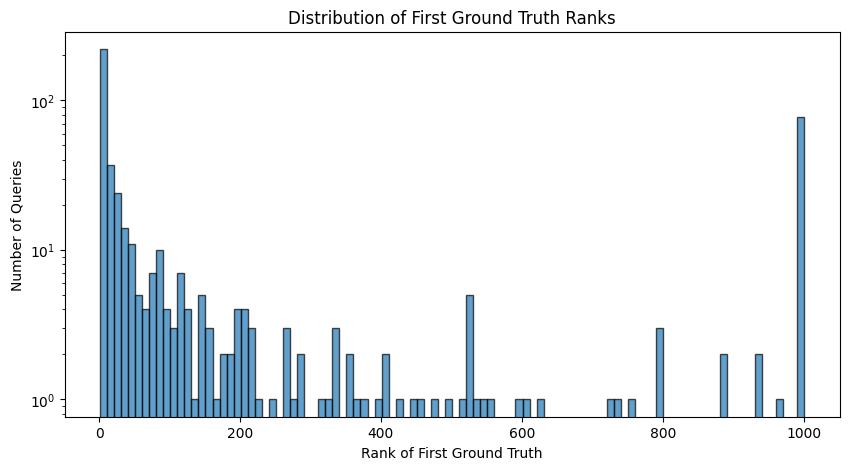

In [11]:
plt.figure(figsize=(10, 5))
plt.hist(result_df['First GT Rank'], bins=np.arange(1, 1002, 10), edgecolor="black", alpha=0.7)
plt.xlabel("Rank of First Ground Truth")
plt.ylabel("Number of Queries")
plt.title("Distribution of First Ground Truth Ranks")
plt.yscale("log")  
plt.show()


In [12]:
invalid_ranks = result_df[result_df["First GT Rank"] == 1001]["First GT Rank"]
print(f"Queries for which GT not retrieved: {len(invalid_ranks)} out of {len(result_df)} ({len(invalid_ranks)/len(result_df) * 100})%")

Queries for which GT not retrieved: 76 out of 500 (15.2)%


In [13]:
first_gt_ranks = result_df['First GT Rank'].tolist()

mrr = np.mean([1/rank for rank in first_gt_ranks if rank <= 1000])
print(f"Mean Reciprocal Rank (MRR): {mrr:.4f}")


Mean Reciprocal Rank (MRR): 0.2930


### Finding patterns in query results

In [14]:
correct_retrievals = df[df["ground_truth_relevance"] == 1]
incorrect_retrievals = df[df["ground_truth_relevance"] == 0]

/tmp/ipykernel_1114622/4025150044.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(incorrect_retrievals['score'], color='r', label='Incorrect Retrievals', shade=True, alpha=0.6)
/tmp/ipykernel_1114622/4025150044.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(correct_retrievals['score'], color='g', label='Correct Retrievals', shade=True, alpha=0.6)


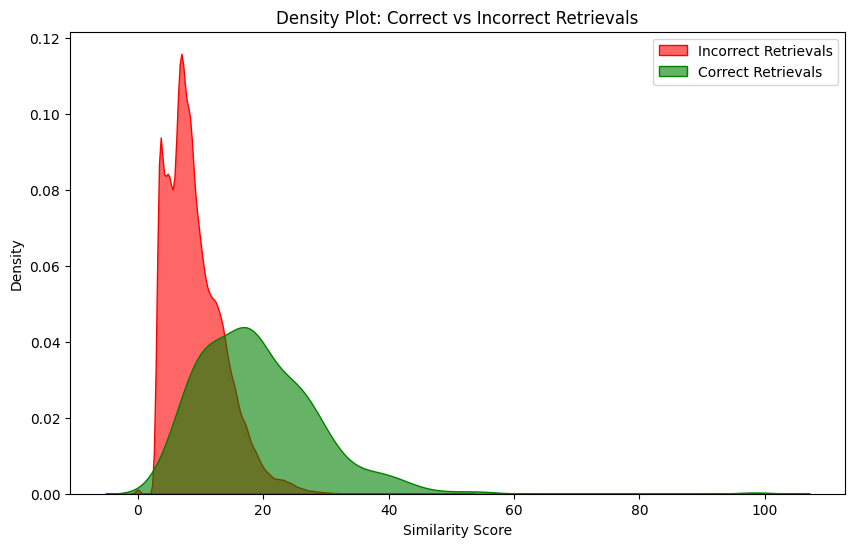

In [15]:
plt.figure(figsize=(10, 6))
sns.kdeplot(incorrect_retrievals['score'], color='r', label='Incorrect Retrievals', shade=True, alpha=0.6)
sns.kdeplot(correct_retrievals['score'], color='g', label='Correct Retrievals', shade=True, alpha=0.6)

plt.xlabel('Similarity Score')
plt.ylabel('Density')
plt.title('Density Plot: Correct vs Incorrect Retrievals')
plt.legend()
plt.show()


In [16]:
df['top_retrieved_score'] = df.groupby('query')['score'].transform('max')
df['score_difference'] = df['top_retrieved_score'] - df['score']

In [17]:
df['score_difference'].describe()

count    500000.000000
mean         15.284972
std           7.243620
min           0.000000
25%          10.586450
50%          13.623493
75%          18.495415
max          76.308164
Name: score_difference, dtype: float64

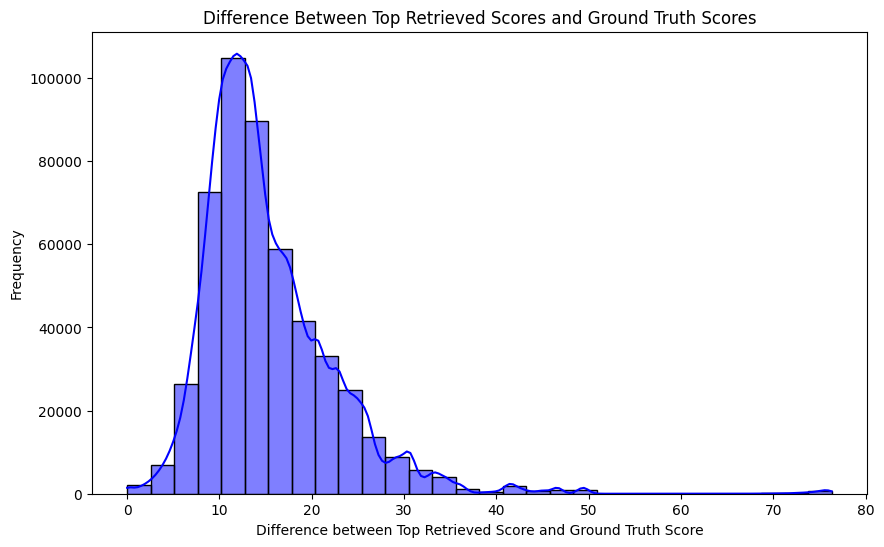

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(df['score_difference'], bins=30, kde=True, color='b')
plt.xlabel('Difference between Top Retrieved Score and Ground Truth Score')
plt.ylabel('Frequency')
plt.title('Difference Between Top Retrieved Scores and Ground Truth Scores')
plt.show()

### Analyzing Term Frequencies & BM25 Impact

In [19]:
def token_overlap(query, explanation):
    query_tokens = set(word for word in query.lower().split() if word not in stop_words)
    explanation_tokens = set(word for word in explanation.lower().split() if word not in stop_words)
    return len(query_tokens.intersection(explanation_tokens))

In [20]:
df["retrieved_overlap"] = df.apply(lambda row: token_overlap(row["query"], row["retrieved_explanation"]), axis=1)

df["ground_truth_overlap"] = df.apply(lambda row: token_overlap(row["query"], row["ground_truth_explanation"]) , axis=1)

In [21]:
df

,query_id,query,retrieved_doc_id,retrieved_doc,retrieved_code,retrieved_explanation,score,ground_truth_relevance,ground_truth_explanation,top_retrieved_score,score_difference,retrieved_overlap,ground_truth_overlap
0,q20105,sort by a token in string python,d1459,how to uppercase or lowercase using lists in p...,"def upcaseTokens(s,l,t):\n """"""Helper parse ...",The doc and code are explaining how to use lis...,17.373021,0,The doc and code both clean a string by splitt...,17.373021,0.000000,2,1
1,q20105,sort by a token in string python,d4312,"python turn string into one hot vector ""alphabet""","def one_hot2string(arr, vocab):\n """"""Conver...",The code snippet provided is a function called...,17.307237,0,The doc and code both clean a string by splitt...,17.373021,0.065784,2,1
2,q20105,sort by a token in string python,d5575,how to reverse sort a list alphanetically in p...,"def sort_nicely(l):\n """"""Sort the given lis...","To sort a list alphanetically in Python, you c...",17.252541,0,The doc and code both clean a string by splitt...,17.373021,0.120480,1,1
3,q20105,sort by a token in string python,d8547,apply lowercase function in series python,"def downcaseTokens(s,l,t):\n """"""Helper pars...",The doc and code are meant to convert each tok...,16.973555,0,The doc and code both clean a string by splitt...,17.373021,0.399466,2,1
4,q20105,sort by a token in string python,d20095,test the number of characters in python list,"def token_list_len(tokenlist):\n """"""\n R...",The doc string explains that the function toke...,16.851489,0,The doc and code both clean a string by splitt...,17.373021,0.521532,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,q20604,how do i unzip file in python,d3913,print first value of a series python,"def first(series, order_by=None):\n """"""\n ...","``<think>Okay, so I'm trying to understand the...",5.300079,0,,19.166635,13.866555,0,0
499996,q20604,how do i unzip file in python,d5236,python numpy check if is inf,"def is_int_vector(l):\n r""""""Checks if l is ...",The function `is_int_vector(l)` checks if `l` ...,5.297487,0,,19.166635,13.869147,0,0
499997,q20604,how do i unzip file in python,d3242,how to get the directory of the file inpython,"def data_directory():\n """"""Return the absol...",The doc and code are providing a way to find t...,5.297060,0,,19.166635,13.869575,1,0
499998,q20604,how do i unzip file in python,d15834,how to remove blank lines of text file with py...,"def cleanLines(source, lineSep=os.linesep):\n ...","To remove blank lines from a text file, you ca...",5.296291,0,,19.166635,13.870343,0,0


In [22]:
print(token_overlap(df['query'][0],df['retrieved_explanation'][0]))

2


In [23]:
retrieved_avg = df["retrieved_overlap"].mean()
ground_truth_avg = df["ground_truth_overlap"].mean()

print(f"Average Token Overlap - Retrieved Explanations: {retrieved_avg:.2f}")
print(f"Average Token Overlap - Ground Truth Explanations: {ground_truth_avg:.2f}")

Average Token Overlap - Retrieved Explanations: 1.05
Average Token Overlap - Ground Truth Explanations: 1.71


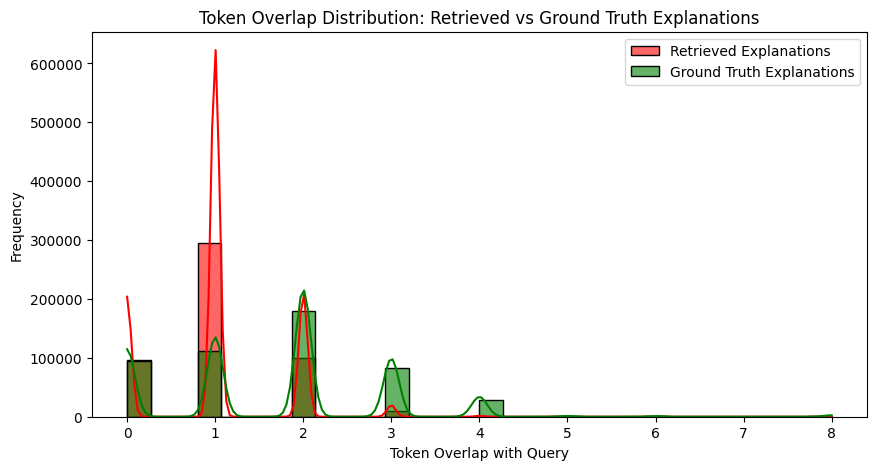

In [24]:
plt.figure(figsize=(10, 5))
sns.histplot(df["retrieved_overlap"], bins=30, color="red", label="Retrieved Explanations", alpha=0.6, kde=True)
sns.histplot(df["ground_truth_overlap"], bins=30, color="green", label="Ground Truth Explanations", alpha=0.6, kde=True)
plt.xlabel("Token Overlap with Query")
plt.ylabel("Frequency")
plt.title("Token Overlap Distribution: Retrieved vs Ground Truth Explanations")
plt.legend()
plt.show()

In [25]:
avg_query_token_size = df["query"].apply(lambda x: len([word for word in x.lower().split() if word not in stop_words])).mean()

print(f"Average Query Token Size: {avg_query_token_size:.2f}")

Average Query Token Size: 4.65


In [26]:
higher_gt_overlap = (df["ground_truth_overlap"] > df["retrieved_overlap"]).sum()
total_rows = len(df)

print(f"Ground Truth Overlap > Retrieved Overlap: {higher_gt_overlap}/{total_rows} ({(higher_gt_overlap/total_rows)*100:.2f}%)")

Ground Truth Overlap > Retrieved Overlap: 274290/500000 (54.86%)
